# 1. Lib Imports

In [1]:
import os
import pathlib
import re
import copy

from sys import getsizeof

import cv2
import xmltodict
import numpy as np
import pandas as pd
import tiffcapture as tc

from tifffile import imsave
from matplotlib import pyplot as pt

%matplotlib inline

# 2. Global vars definition

In [2]:
POSITION = 40
TIME_UNIT_FACTOR = 600
PIXEL_INCH_RATIO = .647
DIAMETER = 12

In [18]:
# path to exit data
exit_dat = '../results/40-47.csv'

# 3. Function defs

In [71]:
def removekey(d, key):
    """
    Remove a key from a  dictionary without destroying the reference
    to removed object (which might be used by other processes)
    """
    if key in d:
        r = dict(d)
        del r[key]
        return r

In [57]:
def parse_trees(links_tab):
    """
    Given 'links in tab statistics' from TrackMate.
    Construct data structures representing trees ('tree') and
    their branching ('branch') respectively.
    
    -   'tree' contains mapping of TREE_ID (which is the same as
        the id of root's SPOT_ID) to its associated tree.
        Each tree is in turn a map of TREE_BRANCH_ID
        (which is the branch's first spot's SPOT_ID)
        to its branch which is represented as list of SPOT_ID's.
    -   'branch' encodes how the tree is structured. It contains
        mapping of TREE_ID to the branching configuration.
        The branching configuration is encoded as mapping of
        BRANCH_ID to its two children's BRANCH_ID.
    """
    
    tree = {}
    branch = {}
    for track in links_tab.TRACK_ID.unique():
    
        sub = links_tab[links_tab.TRACK_ID == track]

        this_lines = {}
        this_branches = {}
        stack = []
    
        groot = sub.iloc[0][3] 
        print("Parsing tree %s" % groot)
        stack.append(groot)
    
        while len(stack) > 0:
        
            root = stack.pop()
            track = [root]
            print("Parsing subtree %s" % root)
            nsub = sub[sub.SPOT_SOURCE_ID == root]
        
            while nsub.index.size > 0:
                if nsub.index.size == 1:
                    this = nsub.iloc[0][4]
                    track.append(this)
                    nsub = sub[sub.SPOT_SOURCE_ID == this]
                else:
                    stack.append(nsub.iloc[0][4])
                    stack.append(nsub.iloc[1][4])
                    this_branches[root] = (nsub.iloc[0][4], nsub.iloc[1][4])
                    print("breaking")
                    break
                
            this_lines[root] = track
            print("adding branch %s" % root)
    
        print("Finishing...")
        tree[groot] = this_lines
        branch[groot] = this_branches
        
    return tree, branch

In [60]:
def extract_values(tree, spots_tab, colnames):
    """
    Extract varoius measurement values from spots statistics and save it
    in format similar to parsed tree. The list of values to be extracted
    from spots statistics is defined in 'colnames' 
    
    The information will be stored in following format:
    map(TYPE:(TREE_ID:TREE_BRANCH:list(VALUES))
    
    """
    
    vals = {}

    for tr in tree:
    
        print("extracting values for %s" % tr)
    
        for colname in colnames:
        
            val_tree = {}
        
            for br in tree[tr]:
            
                brkeys = tree[tr][br]
                brvals = [sits[sits.ID == x][colname].values[0] for x in brkeys]
            
                val_tree[br] = brvals
            
            if colname not in vals:
                vals[colname] = {}
            
            vals[colname][tr] = val_tree
            
    return vals

In [69]:
def filter_trees_by_time(tree, branch, tree_values, min_time=0, max_time=10):
    """
    Filter out trees which measurement time start before or after
    the time as defined in 'min_time' and 'max_time'.
    
    Measurement time is defined as the return value from TrackMate
    encoded as 'POSITION_T'
    """
    
    tree_values_filtered = {}
    tree = copy.deepcopy(tree)
    branch = copy.deepcopy(branch)

    for v in tree_values.keys():
        tree_values_filtered[v] = {}

    for key in tree_values['POSITION_T'].keys():
    
        if (tree_values['POSITION_T'][key][key][0] >= min_time) and (tree_values['POSITION_T'][key][key][0] <= max_time):
            for k in tree_values_filtered.keys():
                tree_values_filtered[k][key] = tree_values[k][key]
        else:
            tree = removekey(tree, key)
            branch = removekey(branch, key)
                
    return  tree, branch, tree_values_filtered 

In [63]:
def assign_tree_to_contours(tree_vals, contours):
    """
    Given tree values and recognized contours, compute:
    
    -   'assocs': table listing recognized slit and the TREE_ID
        of singly-placed cell tree located in the slit
    -   'occupancy': list containing the number of cell trees
        located in a slit. NOTE: the list is not associated with
        ordering encoded in 'assocs'
    """

    occuppancy = {x:0 for x in range(len(contours))}
    cell_trees = []
    slits = []

    for tr in svals_filtered['POSITION_X'].keys():
    
        cell_trees.append(tr)

        x = svals_filtered['POSITION_X'][tr][tr][0] / PIXEL_INCH_RATIO
        y = svals_filtered['POSITION_Y'][tr][tr][0] / PIXEL_INCH_RATIO
    
        counter = 0
        match = 0
        matchloc = None
    
        for ct in cts:
        
            if cv2.pointPolygonTest(ct, (x, y), False) > 0:
                occuppancy[counter] += 1
                matchloc = counter
                match += 1
            counter +=  1
        
        if match == 0:
            slits.append(None)
        elif match == 1:
            slits.append(matchloc)
        else:
            print("Tree %s got too many matches" % tr)
        
    assocs = pd.DataFrame({'CELL_LINE': cell_trees, 'SLIT_ID': slits})
    occuppancy = np.array(list(occuppancy.values()))
    
    return assocs, occuppancy

# 3. Data import

In [19]:
track_path = '../test/eli-new-unsync-bf-%d/out-focus/merged/out/tracked/' % POSITION
with open(os.path.join(track_path, 'merged_Tracks.xml')) as fd:
    td = xmltodict.parse(fd.read())
    
with open(os.path.join(track_path, 'merged.xml')) as fd:
    sd = xmltodict.parse(fd.read())
    
ss = pd.read_csv(os.path.join(track_path, 'All Spots statistics.csv'))
ts = pd.read_csv(os.path.join(track_path, 'Track statistics.csv'))
ba = pd.read_csv(os.path.join(track_path, 'Links in tracks statistics.csv'))
sits = pd.read_csv(os.path.join(track_path, 'Spots in tracks statistics.csv'))

## TODO: include the last one file (branch statistics)

# 4. General data observation
## 4.1 Links in tracks statistics

In [25]:
ba.columns

Index([' ', 'Label', 'TRACK_ID', 'SPOT_SOURCE_ID', 'SPOT_TARGET_ID',
       'LINK_COST', 'EDGE_TIME', 'EDGE_X_LOCATION', 'EDGE_Y_LOCATION',
       'EDGE_Z_LOCATION', 'VELOCITY', 'DISPLACEMENT', 'MANUAL_COLOR'],
      dtype='object')

In [20]:
ba

Label  TRACK_ID  SPOT_SOURCE_ID  \
0          1      (ID29292 : ID16917)         0           29292   
1          2      (ID16917 : ID23040)         0           16917   
2          3      (ID23040 : ID35402)         0           23040   
3          4      (ID35402 : ID41288)         0           35402   
4          5      (ID41288 : ID47205)         0           41288   
5          6      (ID47205 : ID52991)         0           47205   
6          7      (ID52991 : ID64728)         0           52991   
7          8      (ID64728 : ID58918)         0           64728   
8          9      (ID58918 : ID70179)         0           58918   
9         10      (ID70179 : ID87086)         0           70179   
10        11      (ID87086 : ID76046)         0           87086   
11        12      (ID76046 : ID81602)         0           76046   
12        13      (ID81602 : ID94141)         0           81602   
13        14      (ID94141 : ID92798)         0           94141   
14        15     (ID92798 : ID109766)         0           92798   
15        16    (ID109766 : ID103088)         0          109766   
16        17    (ID103088 : ID126859)         0          103088   
17        18    (ID126859 : ID115498)         0          126859   
18        19    (ID115498 : ID132511)         0          115498   
19        20    (ID132511 : ID121257)         0          132511   
20        21    (ID121257 : ID138169)         0          121257   
21        22    (ID138169 : ID149624)         0          138169   
22        23    (ID149624 : ID155266)         0          149624   
23        24    (ID155266 : ID143991)         0          155266   
24        25    (ID143991 : ID161019)         0          143991   
25        26    (ID161019 : ID166588)         0          161019   
26        27    (ID166588 : ID172260)         0          166588   
27        28    (ID172260 : ID177975)         0          172260   
28        29    (ID177975 : ID183750)         0          177975   
29        30    (ID183750 : ID189505)         0          183750   
...      ...                      ...       ...             ...   
30438  30439  (ID1785376 : ID1794000)       894         1785376   
30439  30440  (ID1791690 : ID1800418)       895         1791690   
30440  30441  (ID1766937 : ID1775195)       896         1766937   
30441  30442  (ID1775195 : ID1792099)       896         1775195   
30442  30443  (ID1792099 : ID1800775)       896         1792099   
30443  30444  (ID1758820 : ID1767201)       897         1758820   
30444  30445  (ID1803775 : ID1812500)       898         1803775   
30445  30446  (ID1812500 : ID1821271)       898         1812500   
30446  30447  (ID1815567 : ID1824405)       899         1815567   
30447  30448  (ID1824405 : ID1833190)       899         1824405   
30448  30449  (ID1793049 : ID1801647)       900         1793049   
30449  30450  (ID1801647 : ID1810395)       900         1801647   
30450  30451  (ID1810395 : ID1819080)       900         1810395   
30451  30452  (ID1799709 : ID1808224)       901         1799709   
30452  30453  (ID1808224 : ID1817169)       901         1808224   
30453  30454  (ID1817169 : ID1826065)       901         1817169   
30454  30455  (ID1826065 : ID1834766)       901         1826065   
30455  30456  (ID1809610 : ID1818348)       902         1809610   
30456  30457  (ID1818348 : ID1827173)       902         1818348   
30457  30458  (ID1816423 : ID1825283)       903         1816423   
30458  30459  (ID1825283 : ID1833944)       903         1825283   
30459  30460  (ID1792405 : ID1801042)       904         1792405   
30460  30461  (ID1792613 : ID1801255)       905         1792613   
30461  30462  (ID1807724 : ID1816729)       906         1807724   
30462  30463  (ID1806306 : ID1815073)       907         1806306   
30463  30464  (ID1818382 : ID1827209)       908         1818382   
30464  30465  (ID1818677 : ID1827535)       909         1818677   
30465  30466  (ID1819340 : ID1828320)       910         1819340   
30466  30467

## 4.2 Track statistics

In [24]:
ts.columns

Index([' ', 'Label', 'NUMBER_SPOTS', 'NUMBER_GAPS', 'LONGEST_GAP',
       'NUMBER_SPLITS', 'NUMBER_MERGES', 'NUMBER_COMPLEX', 'TRACK_DURATION',
       'TRACK_START', 'TRACK_STOP', 'TRACK_DISPLACEMENT', 'TRACK_INDEX',
       'TRACK_ID', 'TRACK_X_LOCATION', 'TRACK_Y_LOCATION', 'TRACK_Z_LOCATION',
       'TRACK_MEAN_SPEED', 'TRACK_MAX_SPEED', 'TRACK_MIN_SPEED',
       'TRACK_MEDIAN_SPEED', 'TRACK_STD_SPEED', 'TRACK_MEAN_QUALITY',
       'TRACK_MAX_QUALITY', 'TRACK_MIN_QUALITY', 'TRACK_MEDIAN_QUALITY',
       'TRACK_STD_QUALITY'],
      dtype='object')

In [23]:
ts

Label  NUMBER_SPOTS  NUMBER_GAPS  LONGEST_GAP  NUMBER_SPLITS  \
0      1    Track_0           198            9            3              3   
1      2    Track_1            33            0            0              1   
2      3    Track_2           356            9            4              1   
3      4    Track_3           315           30            5              7   
4      5    Track_4            22            0            0              0   
5      6    Track_5           264            6            1              0   
6      7    Track_6           383           12            5              1   
7      8    Track_7            25            0            0              0   
8      9    Track_8           109            3            1              0   
9     10    Track_9           296           17            5              1   
10    11   Track_10           332           19            4              2   
11    12   Track_11             4            0            0              0   
12    13   Track_12           271            7            3              1   
13    14   Track_13           243            7            3              1   
14    15   Track_14           164            8            2              0   
15    16   Track_15           270            8            4              1   
16    17   Track_16           270            7            3              2   
17    18   Track_17           198           13            5              3   
18    19   Track_18           100            4            2              0   
19    20   Track_19            12            0            0              0   
20    21   Track_20            39            0            0              1   
21    22   Track_21             3            0            0              0   
22    23   Track_22           258            4            4              3   
23    24   Track_23           194            4            4              0   
24    25   Track_24            48            8            4              0   
25    26   Track_25           188            2            2              2   
26    27   Track_26           249           14            5              8   
27    28   Track_27           266           13            5              1   
28    29   Track_28            93            3            1              0   
29    30   Track_29           171           14            4              0   
..   ...        ...           ...          ...          ...            ...   
883  884  Track_883             2            0            0              0   
884  885  Track_884             5            0            0              0   
885  886  Track_885             2            0            0              0   
886  887  Track_886             2            0            0              0   
887  888  Track_887             2            0            0              0   
888  889  Track_888             8            1            1              0   
889  890  Track_889             2            0            0              0   
890  891  Track_890             5            1            4              0   
891  892  Track_891             2            0            0              0   
892  893  Track_892             2            0            0              0   
893  894  Track_893             2            0            0              0   
894  895  Track_894             2            0            0              0   
895  896  Track_895             2            0            0              0   
896  897  Track_896             4            1            1              0   
897  898  Track_897             2            0            0              0   
898  899  Track_898             3            0            0              0   
899  900  Track_899             3            0            0              0   
900  901  Track_900             4            0            0              0   
901  902  Track_901             5            0            0              0   
902  903  Track_902             3   

## 4.3 Spots Statistics

In [46]:
ss.columns

Index([' ', 'Label', 'ID', 'TRACK_ID', 'QUALITY', 'POSITION_X', 'POSITION_Y',
       'POSITION_Z', 'POSITION_T', 'FRAME', 'RADIUS', 'VISIBILITY',
       'MANUAL_COLOR', 'MEAN_INTENSITY', 'MEDIAN_INTENSITY', 'MIN_INTENSITY',
       'MAX_INTENSITY', 'TOTAL_INTENSITY', 'STANDARD_DEVIATION',
       'ESTIMATED_DIAMETER', 'CONTRAST', 'SNR'],
      dtype='object')

In [26]:
ss

Label       ID TRACK_ID  QUALITY  POSITION_X  POSITION_Y  \
0          1    ID33793    33793        3   12.770     890.272    1001.556   
1          2    ID34819    34819     None    4.615      90.580    1294.000   
2          3    ID32772    32772       25   23.792     507.248     789.340   
3          4    ID33294    33294       26   14.358    1206.008     882.508   
4          5    ID32784    32784       45   20.520     385.612     791.928   
5          6    ID34833    34833       11    4.817      12.940    1296.588   
6          7    ID34834    34834       99    6.381      33.644    1296.588   
7          8    ID30741    30741     None    3.502     600.416     377.848   
8          9    ID34344    34344      100    3.079     846.276    1149.072   
9         10    ID32299    32299       50   29.082     753.108     698.760   
10        11    ID33335    33335      101    8.783      33.644     892.860   
11        12    ID34359    34359     None    3.079     773.812    1151.660   
12        13    ID30779    30779       93   15.738     864.392     388.200   
13        14    ID32835    32835       71   23.015     170.808     802.280   
14        15    ID29252    29252       72   20.749     760.872      80.228   
15        16    ID34885    34885     None    2.917     732.404    1309.528   
16        17    ID34374    34374     None    3.141     641.824    1156.836   
17        18    ID34379    34379       24    8.463    1270.708    1156.836   
18        19    ID29265    29265     None    3.162    1154.248      82.816   
19        20    ID31322    31322       12   18.936    1206.008     491.720   
20        21    ID32353    32353       64   19.220     561.596     714.288   
21        22    ID30821    30821        4   29.892     559.008     398.552   
22        23    ID29286    29286       83   19.120    1314.704      90.580   
23        24    ID30822    30822       10   18.014     621.120     398.552   
24        25    ID32871    32871       51   19.131    1200.832     804.868   
25        26    ID33898    33898     None    4.288     530.540    1042.964   
26        27    ID29292    29292        0   12.376    1299.176      93.168   
27        28    ID34416    34416     None    2.896     282.092    1169.776   
28        29    ID34931    34931     None    3.234     520.188    1317.292   
29        30    ID29812    29812     None    3.574     144.928     199.276   
...      ...        ...      ...      ...      ...         ...         ...   
34071  34072  ID1834304  1834304     None    3.388     540.892    1099.900   
34072  34073  ID1832827  1832827     None    3.006       5.176     887.684   
34073  34074  ID1827699  1827699      657    3.669     274.328     111.284   
34074  34075  ID1833838  1833838      748    6.033    1224.124    1042.964   
34075  34076  ID1829217  1829217        5   15.292     939.444     346.792   
34076  34077  ID1827173  1827173      902    4.122     243.272      15.528   
34077  34078  ID1831780  1831780       85   16.251    1260.356     750.520   
34078  34079  ID1827742  1827742      641    4.208     142.340     116.460   
34079  34080  ID1831837  1831837       85    8.106    1291.412     758.284   
34080  34081  ID1827222  1827222      732    4.666     199.276      23.292   
34081  34082  ID1827220  1827220      263    7.936    1309.528      20.704   
34082  34083  ID1827209  1827209      908    2.904     647.000      20.704   
34083  34084  ID1828239  1828239      650    4.616    1221.536     194.100   
34084  34085  ID1829261  1829261      707    3.325    1105.076     354.556   
34085  34086  ID1834880  1834880      531   14.155     390.788    1177.540   
34086  34087  ID1834372  1834372      470    8.059     271.740    1110.252   
34087  34088  ID1832889  1832889      417   13.579     773.812     895.448   
34088  34089  ID1834418  1834418      848   10.126    1079.196    1112.840   
34089  34090  ID1828268  1828268      725    2.874      23.292     199.276   
34090  34091  ID1829292  1829292      66

In [28]:
ss[ss.ID == ss.ID.unique()[1]]

Label     ID TRACK_ID  QUALITY  POSITION_X  POSITION_Y  POSITION_Z  \
1  2  ID34819  34819     None    4.615       90.58      1294.0           0   

   POSITION_T  FRAME  ...    MANUAL_COLOR  MEAN_INTENSITY  MEDIAN_INTENSITY  \
1           0      0  ...       -10921639           2.798                 0   

   MIN_INTENSITY  MAX_INTENSITY  TOTAL_INTENSITY  STANDARD_DEVIATION  \
1              0             78             1368               11.25   

   ESTIMATED_DIAMETER  CONTRAST    SNR  
1                19.6      0.59  0.185  

[1 rows x 22 columns]

In [30]:
ss[ss.TRACK_ID == ss.TRACK_ID.unique()[1]]

Label       ID TRACK_ID  QUALITY  POSITION_X  POSITION_Y  \
1          2    ID34819    34819     None    4.615      90.580    1294.000   
7          8    ID30741    30741     None    3.502     600.416     377.848   
11        12    ID34359    34359     None    3.079     773.812    1151.660   
15        16    ID34885    34885     None    2.917     732.404    1309.528   
16        17    ID34374    34374     None    3.141     641.824    1156.836   
18        19    ID29265    29265     None    3.162    1154.248      82.816   
25        26    ID33898    33898     None    4.288     530.540    1042.964   
27        28    ID34416    34416     None    2.896     282.092    1169.776   
28        29    ID34931    34931     None    3.234     520.188    1317.292   
29        30    ID29812    29812     None    3.574     144.928     199.276   
35        36    ID34429    34429     None    3.977     217.392    1172.364   
39        40    ID34442    34442     None    3.163     150.104    1174.952   
42        43    ID29835    29835     None    3.218    1195.656     199.276   
51        52    ID34461    34461     None    3.526      95.756    1177.540   
57        58    ID31927    31927     None    3.433     859.216     603.004   
65        66    ID31974    31974     None    3.704     569.360     613.356   
69        70    ID30960    30960     None    2.933      28.468     437.372   
78        79    ID34086    34086     None    3.499     533.128    1081.784   
80        81    ID28973    28973     None    3.145    1027.436      10.352   
83        84    ID33601    33601     None    5.988     388.200     944.620   
90        91    ID30549    30549     None    3.024     665.116     336.440   
91        92    ID30550    30550     None    3.024     667.704     336.440   
98        99    ID33644    33644     None    2.969     817.808     954.972   
99       100    ID30572    30572     None    3.707     527.952     341.616   
110      111    ID33687    33687     None    3.349     546.068     965.324   
114      115    ID32156    32156     None    2.940     287.268     662.528   
122      123    ID34750    34750     None    3.315     802.280    1268.120   
126      127    ID34762    34762     None    3.399     582.300    1275.884   
131      132    ID29142    29142     None    3.004     965.324      51.760   
139      140    ID29174    29174     None   15.112    1268.120      56.936   
...      ...        ...      ...      ...      ...         ...         ...   
33953  33954  ID1822346  1822346     None    2.949     385.612     654.764   
33960  33961  ID1819867  1819867     None    3.406    1099.900     276.916   
33975  33976  ID1824521  1824521     None    4.343    1237.064     957.560   
33986  33987  ID1818984  1818984     None    3.045     144.928     142.340   
33993  33994  ID1826697  1826697     None    2.976     522.776    1273.296   
33998  33999  ID1826211  1826211     None    2.963     439.960    1182.716   
34004  34005  ID1824714  1824714     None    4.959    1273.296     986.028   
34008  34009  ID1821645  1821645     None    4.688     243.272     553.832   
34010  34011  ID1824253  1824253     None    3.827      75.052     918.740   
34016  34017  ID1832964  1832964     None    8.736     579.712     903.212   
34018  34019  ID1835060  1835060     None    7.762      41.408    1200.832   
34025  34026  ID1835124  1835124     None    3.538      18.116    1206.008   
34027  34028  ID1831538  1831538     None    7.553     504.660     714.288   
34033  34034  ID1827474  1827474     None    2.986      15.528      69.876   
34037  34038  ID1830540  1830540     None    8.305     284.680     553.832   
34039  34040  ID1830068  1830068     None    7.301    1203.420     489.132   
34041  34042  ID1832105  1832105     None   10.926     181.160     797.104   
34049  34050  ID1827526  1827526     None    3.037      75.052      80.228   
34053  34054  ID1835766  1835766     None    3.259     533.128    1312.116   
34058  34059  ID1832218  1832218     Non

In [31]:
ss['TRACK_ID']

0           3
1        None
2          25
3          26
4          45
5          11
6          99
7        None
8         100
9          50
10        101
11       None
12         93
13         71
14         72
15       None
16       None
17         24
18       None
19         12
20         64
21          4
22         83
23         10
24         51
25       None
26          0
27       None
28       None
29       None
         ... 
34071    None
34072    None
34073     657
34074     748
34075       5
34076     902
34077      85
34078     641
34079      85
34080     732
34081     263
34082     908
34083     650
34084     707
34085     531
34086     470
34087     417
34088     848
34089     725
34090     669
34091     903
34092      50
34093     890
34094    None
34095    None
34096    None
34097     631
34098      59
34099     910
34100    None
Name: TRACK_ID, dtype: object

In [43]:
ss.groupby('TRACK_ID').size().sort_values(ascending=False)

TRACK_ID
None    2720
85       508
50       419
31       410
91       388
6        383
71       381
44       372
196      370
2        356
72       342
59       334
10       332
3        315
70       312
9        296
33       283
46       275
82       274
12       271
68       271
16       270
15       270
76       266
27       266
5        264
42       263
60       262
63       260
22       258
        ... 
598        2
595        2
591        2
894        2
522        2
523        2
525        2
264        2
527        2
548        2
260        2
906        2
258        2
895        2
552        2
553        2
557        2
565        2
569        2
577        2
249        2
581        2
247        2
246        2
585        2
588        2
589        2
242        2
241        2
881        2
dtype: int64

In [44]:
largest = ss.groupby('TRACK_ID').size().sort_values(ascending=False).reset_index(drop=False).values[1,0]

In [50]:
largest_track = ss[ss.TRACK_ID == largest]
largest_track_occ = largest_track.groupby('POSITION_T').size().reset_index(drop=False)

In [48]:
largest_track

Label       ID TRACK_ID  QUALITY  POSITION_X  POSITION_Y  \
113      114    ID32667    32667       85    8.390    1275.884     768.636   
229      230    ID20319    20319       85   17.304    1275.884     768.636   
363      364    ID26594    26594       85   14.202    1278.472     768.636   
453      454    ID38806    38806       85    4.002    1278.472     768.636   
517      518    ID44772    44772       85   12.166    1281.060     771.224   
642      643    ID50568    50568       85    6.365    1286.236     763.460   
771      772    ID56302    56302       85   14.430    1286.236     766.048   
826      827    ID67807    67807       85   19.185    1286.236     766.048   
1021    1022    ID62230    62230       85    8.916    1291.412     763.460   
1164    1165    ID73526    73526       85   12.616    1283.648     768.636   
1237    1238    ID90355    90355       85   13.642    1286.236     771.224   
1421    1422    ID79170    79170       85   16.536    1291.412     768.636   
1631    1632    ID84756    84756       85   18.839    1288.824     768.636   
1733    1734    ID99847    99847       85   10.750    1286.236     771.224   
1865    1866    ID99576    99576       85   12.274    1288.824     768.636   
2078    2079   ID113011   113011       85   13.835    1286.236     768.636   
2224    2225   ID106207   106207       85   18.722    1286.236     771.224   
2259    2260   ID130075   130075       85   15.140    1286.236     771.224   
2409    2410   ID118835   118835       85    9.731    1286.236     768.636   
2514    2515   ID135718   135718       85   13.358    1291.412     771.224   
2615    2616   ID124486   124486       85    8.776    1288.824     768.636   
2743    2744   ID141539   141539       85    5.904    1288.824     768.636   
2850    2851   ID152808   152808       85    5.698    1288.824     771.224   
2981    2982   ID158602   158602       85   12.711    1286.236     766.048   
3076    3077   ID147271   147271       85    7.400    1288.824     771.224   
3284    3285   ID169848   169848       85    8.181    1286.236     771.224   
3407    3408   ID175588   175588       85   12.336    1286.236     771.224   
3417    3418   ID181249   181249       85   10.481    1286.236     771.224   
3569    3570   ID187126   187126       85   11.429    1286.236     768.636   
3655    3656   ID192701   192701       85    5.194    1286.236     768.636   
...      ...        ...      ...      ...      ...         ...         ...   
32579  32580  ID1716596  1716596       85    5.326    1260.356     763.460   
32619  32620  ID1717253  1717253       85    8.719    1286.236     750.520   
32634  32635  ID1717374  1717374       85   14.960    1257.768     758.284   
32712  32713  ID1717208  1717208       85   12.805    1268.120     747.932   
32783  32784  ID1729242  1729242       85   13.630    1265.532     747.932   
32796  32797  ID1729266  1729266       85    8.311    1286.236     750.520   
32917  32918  ID1737498  1737498       85    3.533    1288.824     750.520   
32926  32927  ID1737473  1737473       85   14.661    1268.120     747.932   
32980  32981  ID1754644  1754644       85   20.225    1265.532     750.520   
33130  33131  ID1746074  1746074       85   15.403    1262.944     750.520   
33131  33132  ID1746075  1746075       85    3.106    1286.236     750.520   
33262  33263  ID1763064  1763064       85    8.608    1286.236     750.520   
33264  33265  ID1763063  1763063       85    8.994    1257.768     750.520   
33399  33400  ID1771387  1771387       85    9.794    1286.236     753.108   
33404  33405  ID1771364  1771364       85   10.730    1260.356     750.520   
33408  33409  ID1771409  1771409       85   10.887    1273.296     755.696   
33517  33518  ID1779667  1779667       85    7.355    1286.236     753.108   
33518  33519  ID1779666  1779666       85   21.211    1260.356     753.108   
33525  33526  ID1779709  1779709       85   10.320    1273.296     758.284   
33542  33543  ID1787965  1787965       8

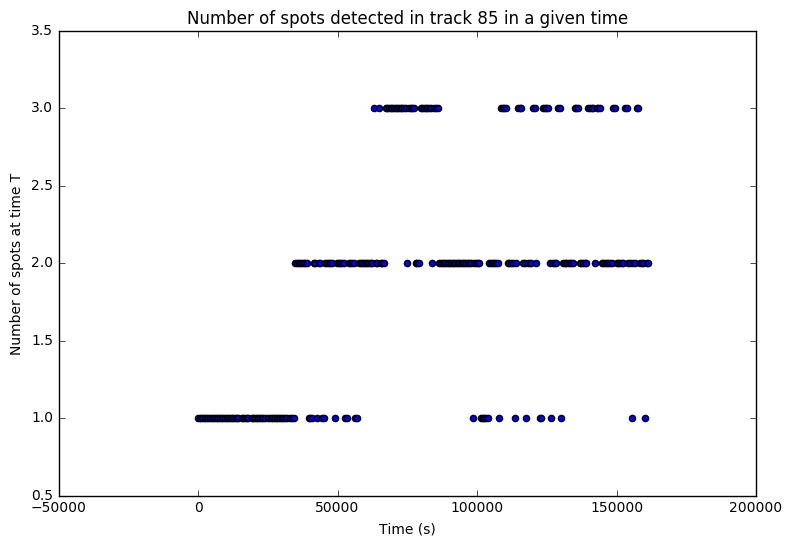

In [55]:
pt.scatter(largest_track_occ.POSITION_T, largest_track_occ[0])

frame = pt.gcf()
frame.set_size_inches(9, 6)

pt.title("Number of spots detected in track %s in a given time" % largest)
pt.xlabel("Time (s)")
pt.ylabel("Number of spots at time T")

# 5. Data Import  and Parsing

In [58]:
tree, branch = parse_trees(ba)

Parsing tree 29292
Parsing subtree 29292
breaking
adding branch 29292
Parsing subtree 396233
adding branch 396233
Parsing subtree 396191
breaking
adding branch 396191
Parsing subtree 549111
adding branch 549111
Parsing subtree 549139
breaking
adding branch 549139
Parsing subtree 901924
adding branch 901924
Parsing subtree 901883
adding branch 901883
Finishing...
Parsing tree 29303
Parsing subtree 29303
breaking
adding branch 29303
Parsing subtree 138144
adding branch 138144
Parsing subtree 138143
adding branch 138143
Finishing...
Parsing tree 33558
Parsing subtree 33558
breaking
adding branch 33558
Parsing subtree 435064
adding branch 435064
Parsing subtree 435026
adding branch 435026
Finishing...
Parsing tree 33793
Parsing subtree 33793
breaking
adding branch 33793
Parsing subtree 176502
breaking
adding branch 176502
Parsing subtree 535614
breaking
adding branch 535614
Parsing subtree 571305
adding branch 571305
Parsing subtree 571286
breaking
adding branch 571286
Parsing subtree 6126

In [61]:
svals = extract_values(tree, sits, ['POSITION_T', 'POSITION_X', 'POSITION_Y', 'TOTAL_INTENSITY', 'QUALITY'])

extracting values for 712363
extracting values for 32772
extracting values for 1153029
extracting values for 601089
extracting values for 1042443
extracting values for 788492
extracting values for 727054
extracting values for 32784
extracting values for 34833
extracting values for 34834
extracting values for 1607917
extracting values for 739348
extracting values for 1505966
extracting values for 892954
extracting values for 751643
extracting values for 29360
extracting values for 751651
extracting values for 636593
extracting values for 946217
extracting values for 620586
extracting values for 1316907
extracting values for 880684
extracting values for 985136
extracting values for 893889
extracting values for 1818677
extracting values for 514104
extracting values for 30779
extracting values for 1226815
extracting values for 1159232
extracting values for 32835
extracting values for 1392982
extracting values for 915525
extracting values for 608326
extracting values for 716873
extracting v

# 6. Filter tree out by time

In [73]:
tree, branch, svals = filter_trees_by_time(tree, branch, svals)

In [93]:
svals

{'POSITION_T': {16750: {16750: [600, 1200, 1800, 2400, 3000, 3600, 4200]},
  22144: {22144: [600, 1200]},
  27192: {27192: [1200, 1800, 2400]},
  28085: {28085: [1200, 1800, 2400]},
  29001: {29001: [0,
    600,
    1200,
    1800,
    2400,
    3000,
    3600,
    4200,
    4800,
    5400,
    6000,
    6600,
    7200,
    7800,
    8400,
    9000,
    9600,
    10200,
    10800,
    11400,
    12000,
    12600,
    13200,
    13800,
    14400,
    15000,
    15600,
    16200,
    16800,
    17400,
    18000,
    18600,
    19200,
    19800,
    20400,
    21000,
    21600,
    22200,
    22800,
    23400,
    24000,
    24600,
    25200,
    25800,
    26400,
    27000,
    27600,
    28200,
    28800,
    29400,
    30000,
    30600,
    31200,
    31800,
    32400,
    33000,
    33600,
    34200,
    34800,
    35400,
    36000,
    36600,
    37200,
    37800,
    38400,
    39000,
    39600,
    40200,
    40800,
    41400,
    42000,
    42600,
    43200,
    43800,
    44400,


# 7. Slit Contour Analysis

In [74]:
path = '../test/eli-new-unsync-bf-%d/in-focus/before' % POSITION
impath = 'bf_in-focusxy%dc1c1-mask.tif' % POSITION
imorigpath = 'bf_in-focusxy%dc1c1.tif' % POSITION
immask = '../test/eli-new-unsync-bf-%d/out-focus/merged/merged.tif' % POSITION

im = cv2.imread(os.path.join(path, impath))
imorig = cv2.imread(os.path.join(path, imorigpath))
immask = cv2.imread(immask)

gray= cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
im2, contours, hierarchy  = cv2.findContours(gray,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

In [75]:
gray

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   2, 130,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ..., 
       [  0,   2,   1, ...,   0,   0,   0],
       [  0,   2,   2, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [76]:
plot_others = False

In [77]:
## show the 0-th contour in one element contour list

if plot_others:
    cnt = contours[4]
    cv2.drawContours(im, [cnt], 0, (255, 0, 0), 3)
    cv2.imshow("Keypoints", im)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
## show all contours in the lsist

if plot_others:
    cv2.drawContours(im, contours, -1, (255, 0, 0),1)
    cv2.imshow("Keypoints", im)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

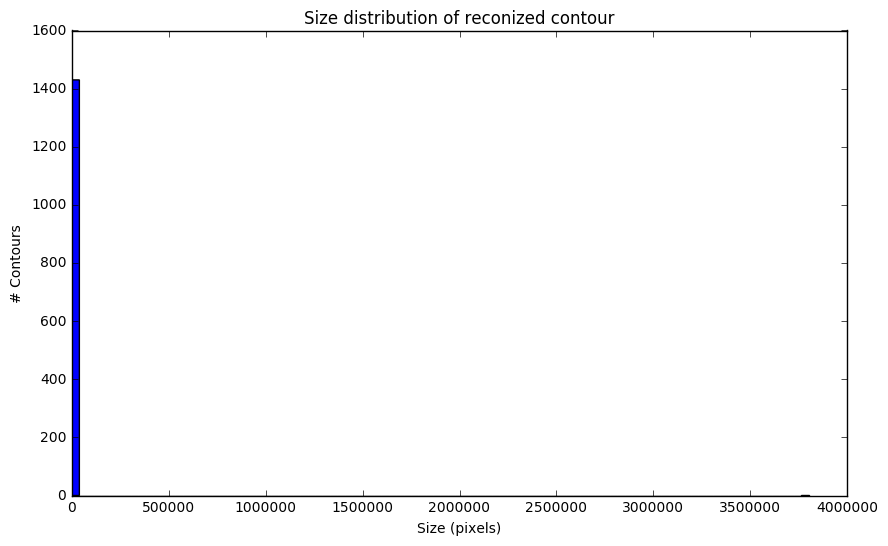

In [78]:
pt.hist(np.array([cv2.contourArea(x) for x  in contours]), bins=100)
pt.gcf().set_size_inches(10, 6)

pt.title("Size distribution of reconized contour")
pt.xlabel("Size (pixels)")
pt.ylabel("# Contours")

9480.5


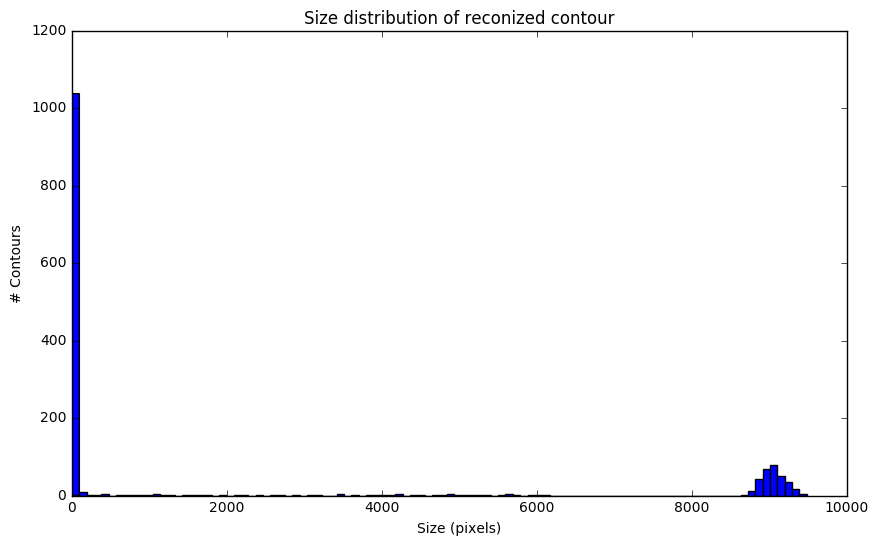

In [79]:
## plot the size of contours

sizes = np.array([cv2.contourArea(x) for x  in contours])
sizes = sizes[sizes < sizes.max()]

pt.title("Size distribution of reconized contour")
pt.xlabel("Size (pixels)")
pt.ylabel("# Contours")
pt.hist(sizes, bins=100)
print(max(sizes))
pt.gcf().set_size_inches(10, 6)

9480.5


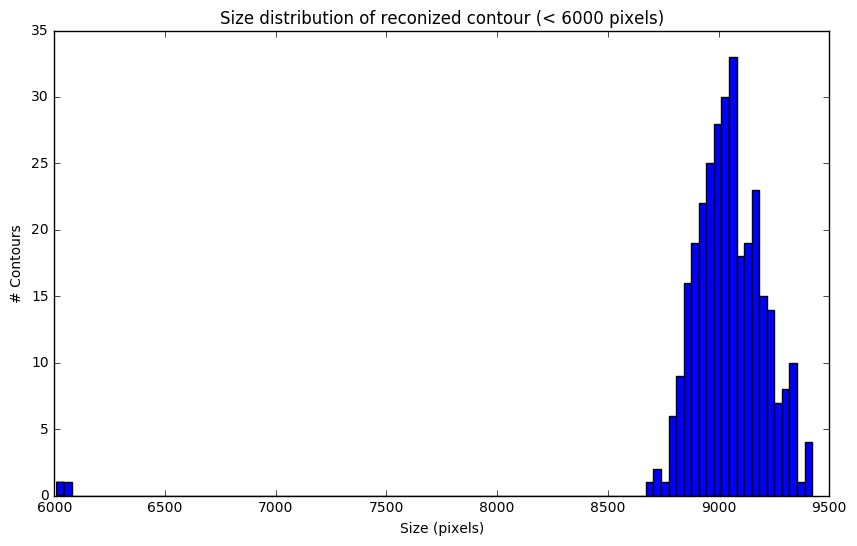

In [80]:
## plot the size of putative correct contours

pt.hist(sizes[(sizes < sizes.max()) & (sizes > 6000)], bins=100)
print(max(sizes))
pt.title("Size distribution of reconized contour (< 6000 pixels)")
pt.xlabel("Size (pixels)")
pt.ylabel("# Contours")
pt.gcf().set_size_inches(10, 6)

In [81]:
sizes = np.array([cv2.contourArea(x) for x  in contours])
sizes = sizes[(sizes < sizes.max()) & (sizes > 6000)]

cts  = []
dist = []

for ct in contours:
    ct_area = cv2.contourArea(ct)
    if (ct_area < 10000) and (ct_area > 7000):
        cts.append(ct)
        dist.append(ct_area)

In [82]:
## draw contours and write file

imc = im.copy()
cv2.drawContours(imc, cts, -1, (255, 0, 0), 2)
cv2.imwrite(os.path.join(path, 'im_contours.tiff'), imc);

In [83]:
## check whether a point lies inside/on/outside the contour
cv2.pointPolygonTest(contours[0], (1199, 2046), False)

-1.0

In [84]:
## distance between a point and the contour
cv2.pointPolygonTest(contours[0], (1199, 2046), True) <= 0

True

# 8. Tree-Slit Assignment

In [85]:
assocs, occuppancy = assign_tree_to_contours(svals, cts)

In [90]:
print("# of trees in slit: %d" % assocs[~assocs.SLIT_ID.isnull()].index.size)
print("Ratio  of cell lines not identified to specific slit: %f" % (assocs[assocs.SLIT_ID.isnull()].index.size / assocs.index.size))
print("ratio of slit not associated with any cell lineage: %f" % (occuppancy[occuppancy == 0].size / occuppancy.size))

# of trees in slit: 78
Ratio  of cell lines not identified to specific slit: 0.297297
ratio of slit not associated with any cell lineage: 0.778846


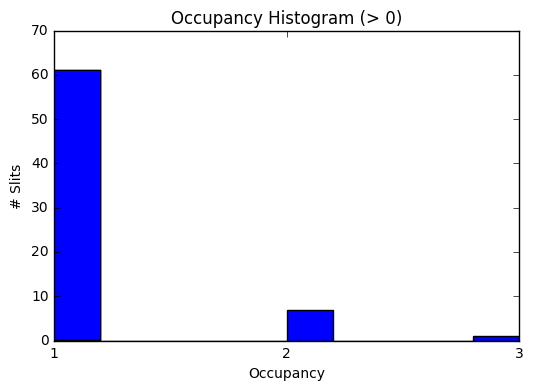

In [88]:
pt.hist(occuppancy[occuppancy > 0])
pt.xticks(np.array(range(max(occuppancy))) + 1)
pt.xlabel("Occupancy")
pt.ylabel("# Slits")
pt.title("Occupancy Histogram (> 0)")

# pt.gcf().set_size_inches(8, 5)

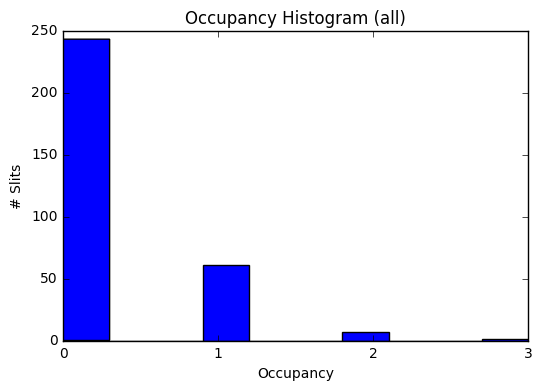

In [91]:
pt.hist(list(occuppancy))
pt.xticks(range(max(occuppancy) + 1))
pt.xlabel("Occupancy")
pt.ylabel("# Slits")
pt.title("Occupancy Histogram (all)")

# pt.gcf().set_size_inches(8, 5)